In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [169]:
df = pd.read_csv(r"C:\Users\2313758A\OneDrive - University of Glasgow\13. Python\Kaggle Datasets\Electricity consumption UK 2009-2024\historic_demand_2009_2024_noNaN.csv", low_memory=False)

In [170]:
df["settlement_date"] = pd.to_datetime(df["settlement_date"])
df = df.set_index("settlement_date")
df = df.asfreq("30min")
print(df.index.freq)

<30 * Minutes>


Extract time based features.

In [171]:
df["hour"] = df.index.hour
df["dayofweek"] = df.index.day_of_week
df["month"] = df.index.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

In [172]:
print(df["is_weekend"].shape)
print(df["dayofweek"].shape)
print(df["hour"].shape)

(279264,)
(279264,)
(279264,)


In [173]:
df["lag_1"] = df["nd"].shift(1)
df["lag_24"] = df["nd"].shift(48)
df["lag_48"] = df["nd"].shift(96)
df["lag_168"] = df["nd"].shift(48 * 7)

This will tell the model what the demand looked like just before the current time.

shift(n) moves values down by n rows.

In [174]:
df["rolling_24h_mean"] = df["nd"].rolling(window=48).mean()
df["rolling_24h_std"] = df["nd"].rolling(window=48).std()
df["rolling_7d_mean"] = df["nd"].rolling(window=48*7).mean()

In [176]:
target = df["nd"]

In [177]:
print(df[["nd", "hour", "dayofweek", "month", "is_weekend"]].head())


                          nd  hour  dayofweek  month  is_weekend
settlement_date                                                 
2009-01-01 00:00:00  37910.0     0          3      1           0
2009-01-01 00:30:00  38047.0     0          3      1           0
2009-01-01 01:00:00  37380.0     1          3      1           0
2009-01-01 01:30:00  36426.0     1          3      1           0
2009-01-01 02:00:00  35687.0     2          3      1           0


In [178]:
df.isna().sum()

settlement_period             752
period_hour                   752
nd                            752
tsd                           752
england_wales_demand          752
embedded_wind_generation      752
embedded_wind_capacity        752
embedded_solar_generation     752
embedded_solar_capacity       752
non_bm_stor                   752
pump_storage_pumping          752
ifa_flow                      752
ifa2_flow                     752
britned_flow                  752
moyle_flow                    752
east_west_flow                752
nemo_flow                     752
is_holiday                    752
hour                            0
dayofweek                       0
month                           0
is_weekend                      0
lag_1                         753
lag_24                        800
lag_48                        848
lag_168                      1088
rolling_24h_mean             1833
rolling_24h_std              1833
rolling_7d_mean              8171
dtype: int64

In [179]:
df = df.dropna()

In [184]:
feature_cols = [
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "lag_1",
    "lag_24",
    "lag_48",
    "lag_168",
    "rolling_24h_mean",
    "rolling_24h_std",
    "rolling_7d_mean"
]
target_col = "nd"

In [185]:
X = df[feature_cols]
y = df[target_col]

In [186]:
train = df.loc["2009":"2021"]
val = df.loc["2022":"2023"]
test = df.loc["2024"]

In [187]:
X_train = train[feature_cols]
y_train = train[target_col]

X_val = val[feature_cols]
y_val = val[target_col]

X_test = test[feature_cols]
y_test = test[target_col]

In [188]:
print(X_train.shape, X_val.shape, X_test.shape)

(220726, 11) (34364, 11) (15982, 11)


In [234]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, accuracy_score

RandomForestRegressor works well on tabular data

In [190]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1, #Essentially saying use all CPU threads
    random_state=42 #Hitchhikers Guide!
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [191]:
y_val_prediction = rf.predict(X_val)

In [ ]:
mae_val = mean_absolute_error(y_val, y_val_prediction)
rmse_val = root_mean_squared_error(y_val, y_val_prediction)


print(f"Validation MAE:", mae_val, "Unit (MW)")
print(f"Validation RMSE:", rmse_val, "Unit (MW)")


Validation MAE: {mae_val}.2f Unit (MW)
Validation RMSE: 374.5495366336879 Unit (MW)


In [196]:
val_results = pd.DataFrame({
    "actual": y_val,
    "predicted": y_val_prediction,
})

In [197]:
print(val_results.head())

                      actual  predicted
settlement_date                        
2022-01-01 00:00:00  21940.0  21514.795
2022-01-01 00:30:00  22427.0  21097.655
2022-01-01 01:00:00  21896.0  22033.035
2022-01-01 01:30:00  20693.0  21592.275
2022-01-01 02:00:00  19481.0  20346.015


In [200]:
week_slice = val_results.loc["2023-01-01":"2023-01-07"]

In [216]:
def figure_design():
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(axis="both",direction="in", top=True, right=True)

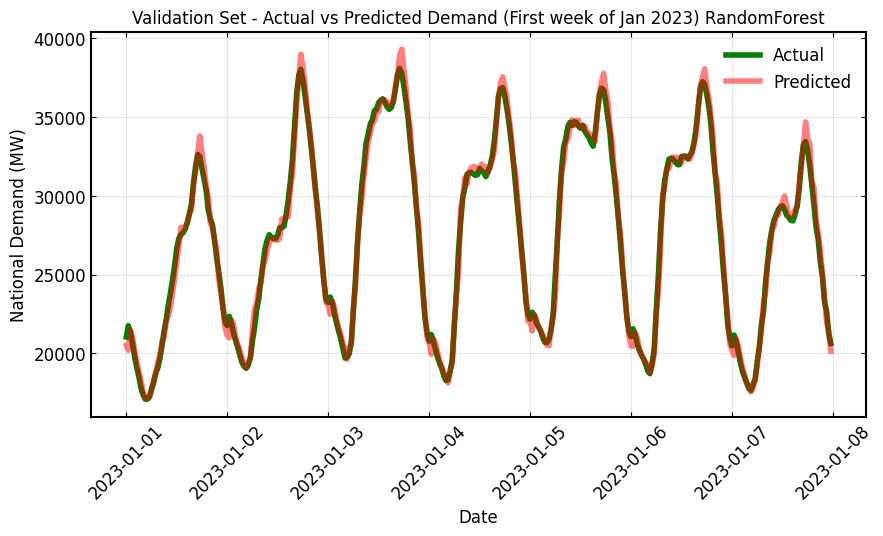

In [215]:
plt.figure(figsize=(10, 5))

plt.plot(week_slice.index, week_slice["actual"], label="Actual", linewidth=4, color="green")
plt.plot(week_slice.index, week_slice["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Validation Set - Actual vs Predicted Demand (First week of Jan 2023) RandomForest")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [230]:
day_slice = val_results.loc["2022-05-01":"2022-05-01"]

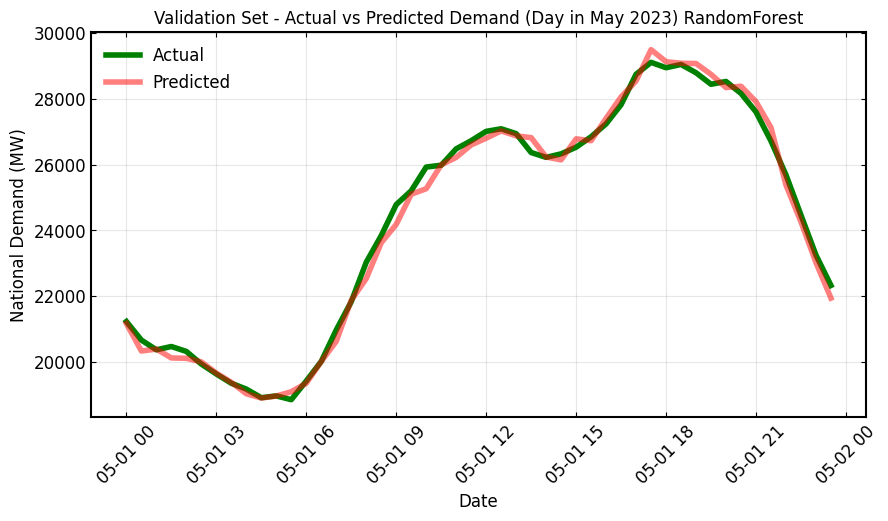

In [233]:
plt.figure(figsize=(10, 5))

plt.plot(day_slice.index, day_slice["actual"], label="Actual", linewidth=4, color="green")
plt.plot(day_slice.index, day_slice["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Validation Set - Actual vs Predicted Demand (Day in May 2023) RandomForest")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [241]:
y_test_prediction = rf.predict(X_test)

In [243]:
y_test_mae = mean_absolute_error(y_test, y_test_prediction)
y_test_rsme = root_mean_squared_error(y_test, y_test_prediction)

print("y_test MAE:", y_test_mae, "MW")
print("y_test RSME:", y_test_rsme, "MW")

y_test MAE: 293.63840946064323 MW
y_test RSME: 394.0551646490119 MW


In [244]:
test_results = pd.DataFrame({
    "actual": y_test,
    "predicted": y_test_prediction,
})

In [245]:
week_2024 = test_results.loc["2024-01-10":"2024-01-17"]

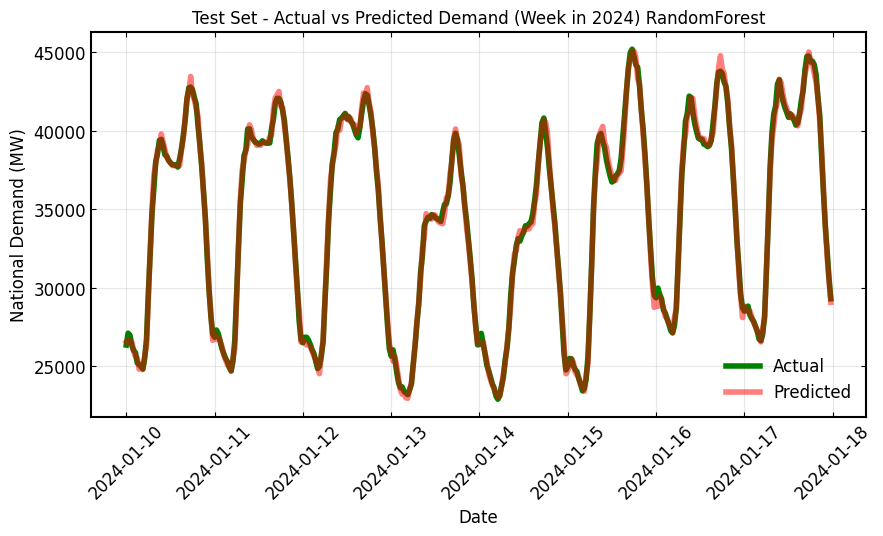

In [247]:
plt.figure(figsize=(10, 5))

plt.plot(week_2024.index, week_2024["actual"], label="Actual", linewidth=4, color="green")
plt.plot(week_2024.index, week_2024["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Test Set - Actual vs Predicted Demand (Week in 2024) RandomForest")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

Model works extremely well with selected parameters. Didn't over fit the validation test and gave similar errors on the test set, overall pretty good!

In [248]:
importance = rf.feature_importances_
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importance
}).sort_values(by="importance", ascending=False)

print(feature_importance)

             feature  importance
4              lag_1    0.980475
0               hour    0.013609
5             lag_24    0.001382
7            lag_168    0.001194
10   rolling_7d_mean    0.000744
2              month    0.000649
8   rolling_24h_mean    0.000646
6             lag_48    0.000412
1          dayofweek    0.000359
9    rolling_24h_std    0.000318
3         is_weekend    0.000212


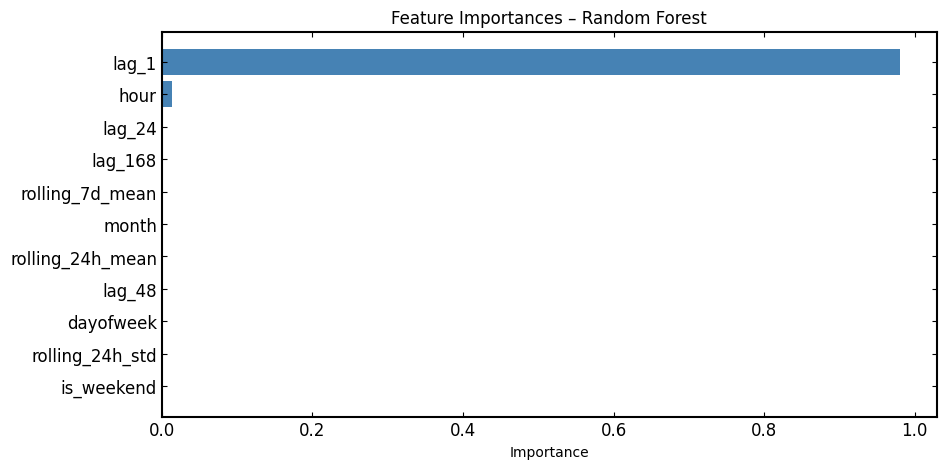

In [249]:
plt.figure(figsize=(10,5))
plt.barh(feature_importance["feature"], feature_importance["importance"], color="steelblue")
plt.xlabel("Importance")
plt.title("Feature Importances – Random Forest")
plt.gca().invert_yaxis()  # biggest at top
figure_design()
plt.show()

This was not unexpected but the degree of importance explains the over/under-estimation at peaks and troughs. For a simple model this works fine. However, I would like to capture those peaks and troughs. This could maybe be achieved using a gradient boosting model. This should take more information from other features and not rely solely on the past 30mins.